# Jogos Evolutivos

## Imports

In [11]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
from matplotlib import colors
plt.rcParams["figure.figsize"] = (10,6)

from tqdm.notebook import tqdm
from typing import List,Callable,Dict,Union
import itertools


## Funções e Classes

In [12]:
class Grid:
    """
    Classe que implementa uma grid 2D como um vetor 1D. 
    (Essencialmente um wrapper do np.array)
    """
    def __init__(self,n_rows:int,n_cols:int,start_rand_array:bool=True,rand_seed:int=2022,
                 array_start_value:int=None,is_torus:bool=True)->None:
        self.n_rows=n_rows
        self.n_cols=n_cols
        self.array_start_value=array_start_value
        self.num_cells = n_rows*n_cols
        self.is_torus = is_torus
        if start_rand_array:
            self.init_randint_array(rand_seed)
        else:
            self.array = array_start_value * np.ones(self.num_cells,dtype=np.int32)
        
    def init_randint_array(self,seed:int,low:int=0,
                           high:int=2)->None:
        """
        Inicializa uma grid aleatória
        """
        np.random.seed(seed)
        self.array = np.random.randint(low=low,high=high,size=self.num_cells)
        
    def __check_input(self,row:int,col:int)->None:
        """
        Checa se o input é válido
        """
        if row >= self.n_rows or col >= self.n_cols:
            raise ValueError(f"Valor inválido para column/row ({row}/{self.n_rows},{col}/{self.n_cols})")
    
    def cell_to_row_col(self,cell:int)->Union[int,int]:
        """
        Converte um índice de célula para um par (i,j) da grid
        """
        curr_row = cell // self.n_cols
        curr_col = cell % self.n_cols

        return curr_row,curr_col

    def print_grid(self)->None:
        """
        Método print da grid
        """
        for i in range(self.n_rows):
            print(self.array[i*self.n_rows:(i+1)*self.n_rows])

    def __next__(self):
        """
        Método next
        """
        if self.iter_counter < self.num_cells:
            curr_row,curr_col = self.cell_to_row_col(self.iter_counter)
            
            self.iter_counter += 1
            
            return curr_row,curr_col
        else:
            raise StopIteration
            
    def __iter__(self):
        """
        Método iter
        """
        self.iter_counter = 0
        return self
    
    def __convert_torus_input(self,row:int,col:int)->tuple:
        """
        Converte um input de toro para o input esperado pelo array.
        """
        tgt_row = row
        tgt_col = col
        
        if row < 0:
            tgt_row = self.n_rows-1
        elif row >= self.n_rows:
            tgt_row = 0

        if col < 0:
            tgt_col = self.n_cols - 1 
        elif col >= self.n_cols:
            tgt_col = 0 
            
        return tgt_row,tgt_col

    def copy(self):
        """
        Método que cria uma cópia do objeto
        """
        grid_copy = Grid(self.n_rows,self.n_cols,self.array_start_value)
        grid_copy.array = self.array.copy()
        return grid_copy
    
    def get_cell_state(self,row:int,col:int)->int:
        """
        Método get do estado
        """
        
        if not self.is_torus:
            self.__check_input(row,col)
        else:
            tgt_row,tgt_col = self.__convert_torus_input(row,col)
            
        tgt_cell = self.n_cols * tgt_row + tgt_col
        
        return self.array[tgt_cell]
        
    def set_cell_state(self,value:int,row:int,col:int)->None:
        """
        Método set do estado
        """
        if not self.is_torus:
            self.__check_input(row,col)
        else:
            tgt_row,tgt_col = self.__convert_torus_input(row,col)
        
        tgt_cell = self.n_cols * tgt_row + tgt_col
        self.array[tgt_cell]=value
    

In [43]:
def sigmoid(in_value:float):
    """
    Função que computa a sigmoide de uma entrada.
    """
    return 1/(1 + np.exp(-in_value))

def num_des_cells(grid):
    """
    Função que retorna o número de células desertoras na grid
    """
    return grid.array.sum()

def num_coop_cells(grid):
    """
    Função que retorna o número de células cooperadoras na grid
    """
    return grid.num_cells - num_des_cells(grid)

def compute_cell_total_energy(grid:Grid,payoff_matrix:np.array,row:int,col:int):
    """
    Função que computa a energia total E_x de uma célula x
    """
    cell_state = grid.get_cell_state(row,col)
    
    up_neigh_state = grid.get_cell_state(row-1,col)
    down_neigh_state = grid.get_cell_state(row+1,col)
    left_neigh_state = grid.get_cell_state(row,col-1)
    right_neigh_state = grid.get_cell_state(row,col+1)
    
    bonus = (cell_state + 1) % 2
    
    cell_total_energy = bonus + payoff_matrix[cell_state,up_neigh_state] + payoff_matrix[cell_state,down_neigh_state]
    + payoff_matrix[cell_state,left_neigh_state] + payoff_matrix[cell_state,right_neigh_state]
        
    return cell_total_energy

def perform_evolution_step(grid:Grid,payoff_matrix:np.array):
    """
    Função que realiza um passo evolutivo.
    """
    for row,col in iter(grid):
        cell_energy = compute_cell_total_energy(grid,payoff_matrix,row,col)
        # Escolhe vizinho aleatório
        # 0 -> up
        # 1 -> down
        # 2 -> left
        # 3 -> right
        rand_neighbor = np.random.randint(0,4)
        neighbor_row = row
        neighbor_col = col

        if rand_neighbor == 0:
            neighbor_row -= 1
        elif rand_neighbor == 1:
            neighbor_row += 1
        elif rand_neighbor == 2:
            neighbor_col -= 1
        else:
            neighbor_col += 1

        neighbor_energy = compute_cell_total_energy(grid,payoff_matrix,neighbor_row,neighbor_col)

        flip_prob = sigmoid((neighbor_energy - cell_energy)/K_const)
        
        if np.random.uniform() <= flip_prob:
            grid.set_cell_state(grid.get_cell_state(neighbor_row,neighbor_col),row,col)

def perform_evolution_full(num_iter:int,dc_weight:float,seed:int,plot_grid_state:bool=False,plot_grid_state_step:int=None):
    """
    Função que realiza num_iter passos evolutivos
    """
    np.random.seed(seed)
    payoff_matrix = np.array([[1,0],[dc_weight,0]]).reshape(2,2)

    grid = Grid(n_rows,n_cols,rand_seed=seed)

    coop_hist = [num_coop_cells(grid)]
    des_hist = [num_des_cells(grid)]

    for i in range(1,num_iter+1):
        if plot_grid_state and (i % plot_grid_state_step == 0 or i == 1):
            plot_grid(grid,f"Grid State at iter {i} (b={dc_weight}). Red = Cooperative, Blue = Desertive")
        perform_evolution_step(grid,payoff_matrix)
        coop_hist.append(num_coop_cells(grid))
        des_hist.append(num_des_cells(grid))
    return np.array(coop_hist),np.array(des_hist)

In [52]:
def plot_grid_evolution(coop_hist:np.array,des_hist:np.array,
                        n_rows:int,n_cols:int,dc_weight:float,plot_errorbar:bool=False,
                        susc_std:np.array=None,inf_std:np.array=None,rec_std:np.array=None) -> None:
    plt.title(f"Grid evolution (size={n_rows}x{n_cols}),b={dc_weight:.4f}")
    
    plt.plot(coop_hist,'ro',label="Cooperative Cells")
    plt.plot(coop_hist,'r')
    
    plt.plot(des_hist,'yo',label="Desertive Cells")
    plt.plot(des_hist,'y')
    
    
    if plot_errorbar:
        plt.errorbar(np.arange(0,len(coop_hist),1),coop_hist,yerr=susc_std,ecolor='r',label=f"Std",
                                        capsize=5,elinewidth=1,markersize='5')
        plt.errorbar(np.arange(0,len(des_hist),1),des_hist,yerr=inf_std,ecolor='r',
                                        capsize=5,elinewidth=1,markersize='5')
    plt.xlabel("Iteration")
    plt.ylabel("No. cells")

    plt.legend()
    plt.show()

def plot_grid(grid:Grid,title:str)->None:
    data = grid.array.reshape(grid.n_rows,grid.n_cols)

    # create discrete colormap
    fig, ax = plt.subplots()
    c = ax.pcolor(data, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdYlBu', vmin=0.0, vmax=1.0)
    ax.set_yticks(np.arange(data.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(data.shape[1]) + 0.5, minor=False)
    ax.set_title(title)

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)
    plt.xlim( (0, data.shape[1]) )

    plt.show()

## Experimento

* O seguinte experimento tem como objetivo definir os valores b_1,b_2 que definem as fases absorventes do modelo.
* O valor de K utilizado foi de 0.1
* São realizadas 300 iterações

In [48]:
# index 0 = coopera, index 1 = deserta

n_rows = 200
n_cols = 200
num_iter = 300

K_const=0.1

In [49]:
dc_weight_low = 1
dc_weight_high = 2
step = 0.05
plot_grid_state = False

start_seed = 2022
num_seeds = 10

  0%|          | 0/20 [00:00<?, ?it/s]

Densidade de cooperadores = 1.00


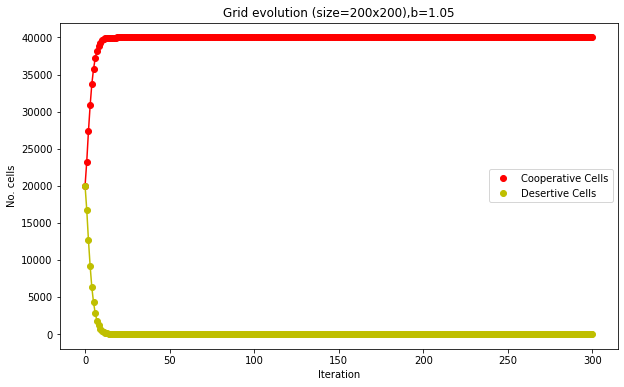

Densidade de cooperadores = 1.00


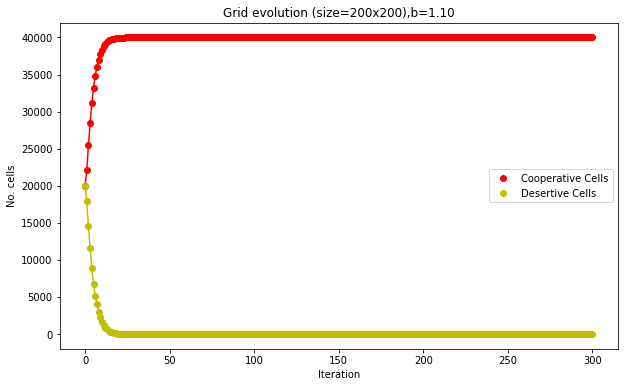

Densidade de cooperadores = 1.00


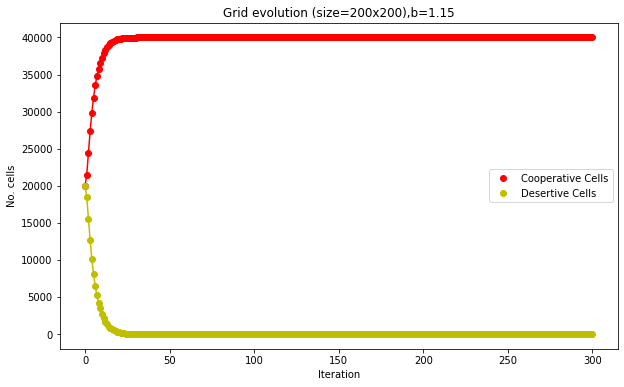

Densidade de cooperadores = 1.00


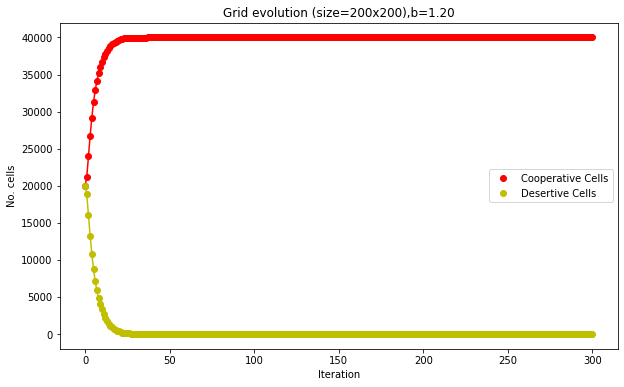

Densidade de cooperadores = 1.00


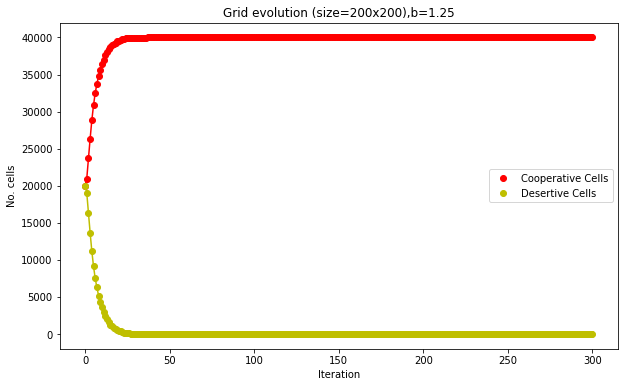

Densidade de cooperadores = 1.00


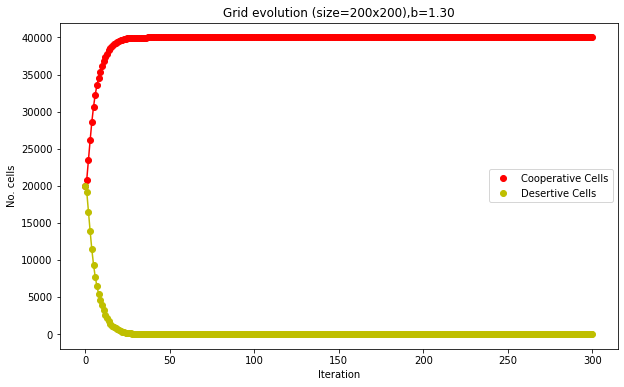

Densidade de cooperadores = 1.00


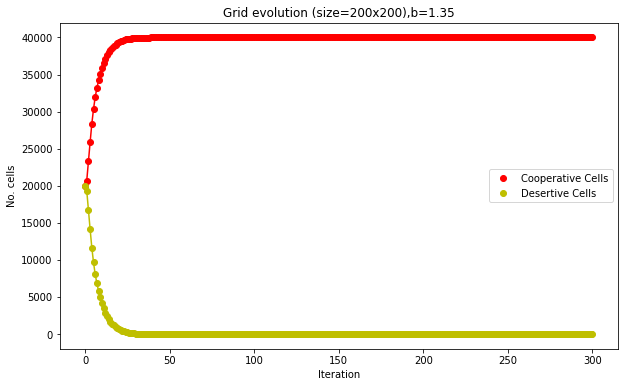

Densidade de cooperadores = 1.00


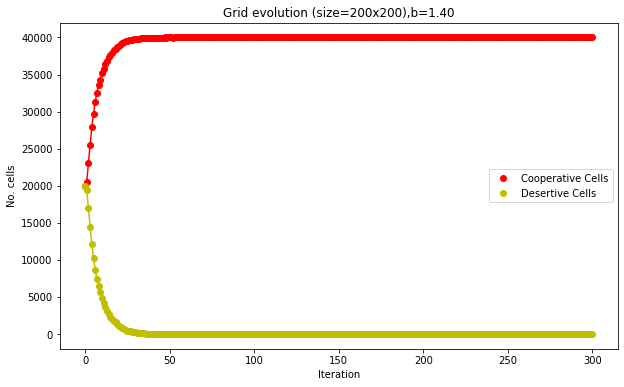

Densidade de cooperadores = 1.00


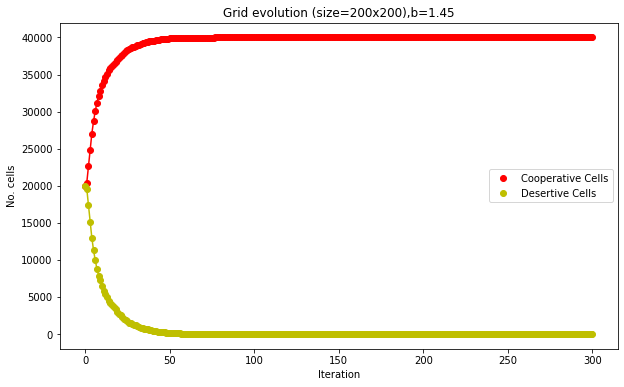

Densidade de cooperadores = 1.00


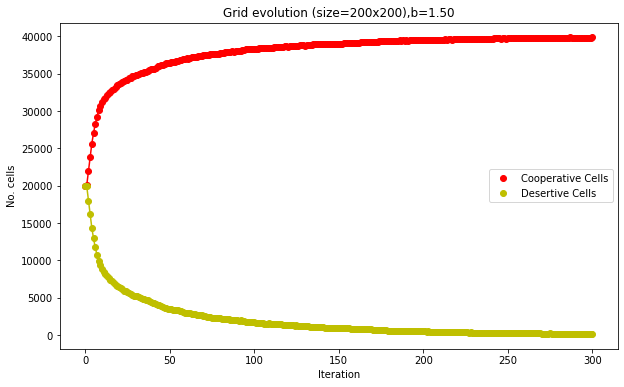

Densidade de cooperadores = 0.77


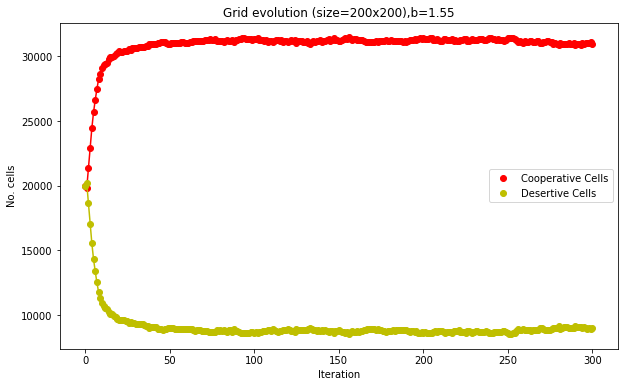

Densidade de cooperadores = 0.72


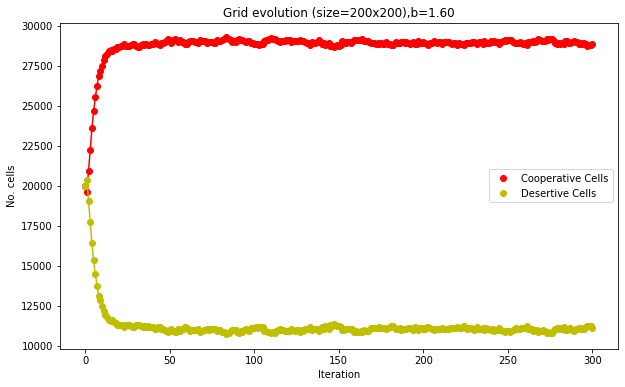

Densidade de cooperadores = 0.70


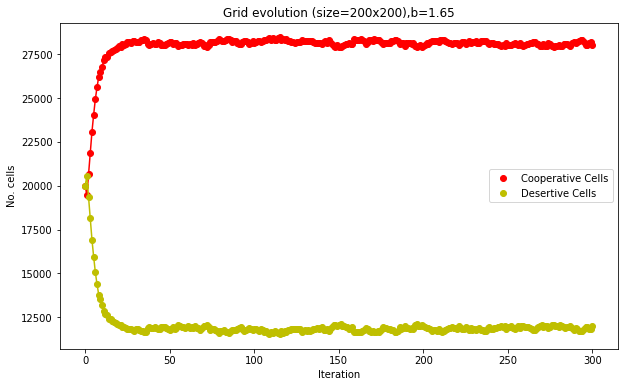

Densidade de cooperadores = 0.69


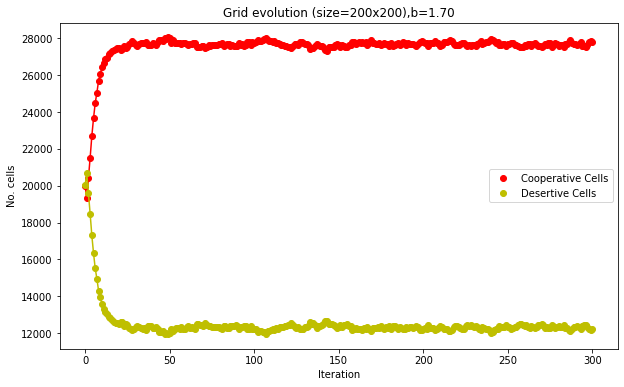

Densidade de cooperadores = 0.68


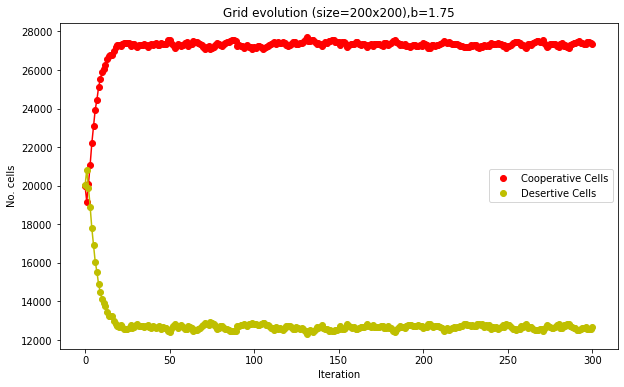

Densidade de cooperadores = 0.67


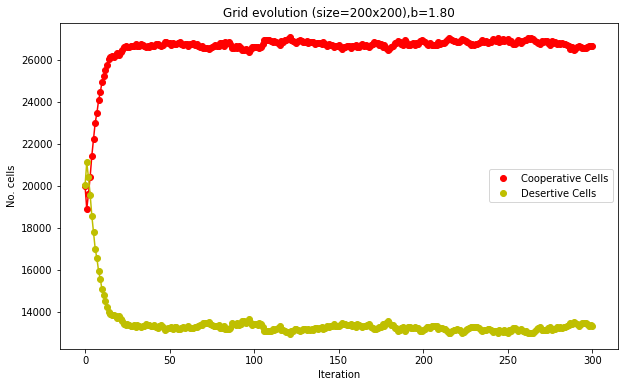

Densidade de cooperadores = 0.65


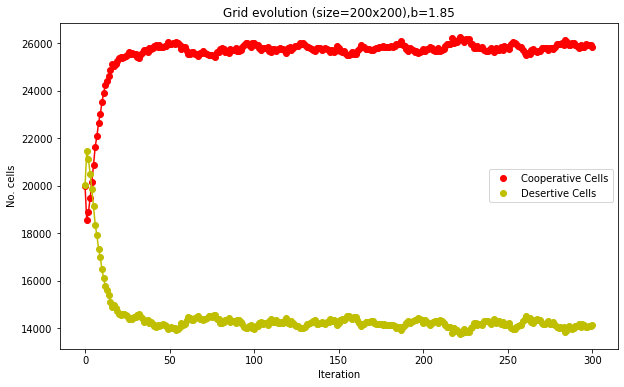

Densidade de cooperadores = 0.60


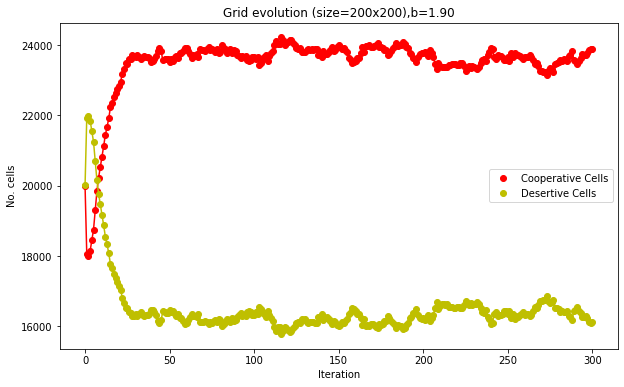

Densidade de cooperadores = 0.47


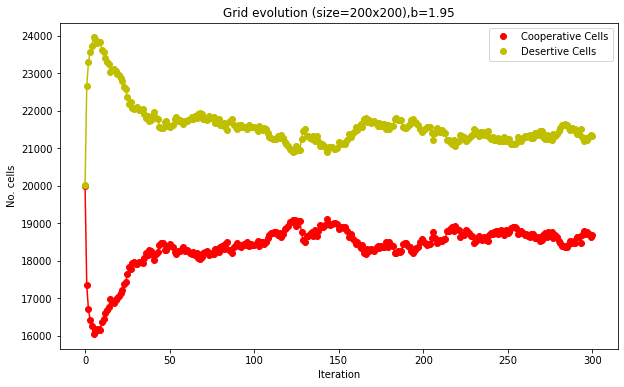

Densidade de cooperadores = 0.01


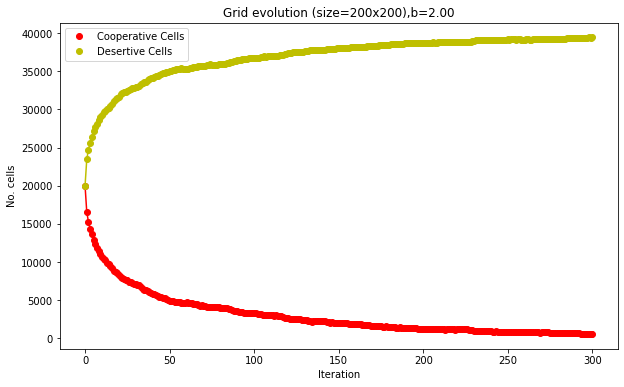

In [40]:
for dc_weight in tqdm(np.arange(dc_weight_low + step,dc_weight_high + step,step)):
    avg_coop_hist = []
    avg_des_hist = []
    for seed in np.arange(start_seed,start_seed+num_seeds):
        coop_hist,des_hist = perform_evolution_full(num_iter,dc_weight,seed,plot_grid_state)
        
        avg_coop_hist.append(coop_hist)
        avg_des_hist.append(des_hist)
    
    avg_coop_hist = np.array(avg_coop_hist).mean(axis=0)
    avg_des_hist = np.array(avg_des_hist).mean(axis=0)
    print(f"Densidade de cooperadores = {avg_coop_hist[-1]/(avg_des_hist[-1]+avg_coop_hist[-1]):.2f}")
    plot_grid_evolution(avg_coop_hist,avg_des_hist,n_rows,n_cols,dc_weight)
    

Lembrando-se que o valor de K definido é 0.1
* A densidade de cooperadores para b = 2 se aproxima de 0.01, e portanto é razoável afirmar que b_2 ≈ 2
* A densidade de cooperadores para b = 1.5 ainda é 1, mas para b = 1.55 é 0.77, e portanto é certo que 1.5 < b_1 < 1.55
* Além disso, é possível observar que o comportamento dos gráfiso segue o esperado: para b < b_1, após tempo suficiente todas as células se tornam cooperativas, para b_1 < b < b_2 o sistema tende a um estado estacionário onde a concentração de cada tipo de célula oscila em torno de um determinado valor, e para b > b_2 observa-se que todas as células se tornam desetoras.

Agora iremos tentar melhorar a estimativa para b_1

  0%|          | 0/2 [00:00<?, ?it/s]

Densidade de cooperadores = 0.99


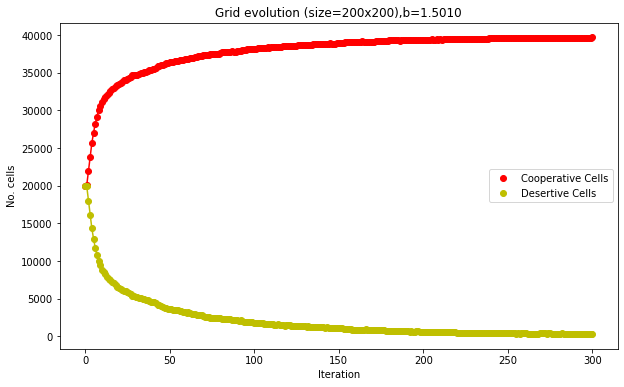

Densidade de cooperadores = 0.99


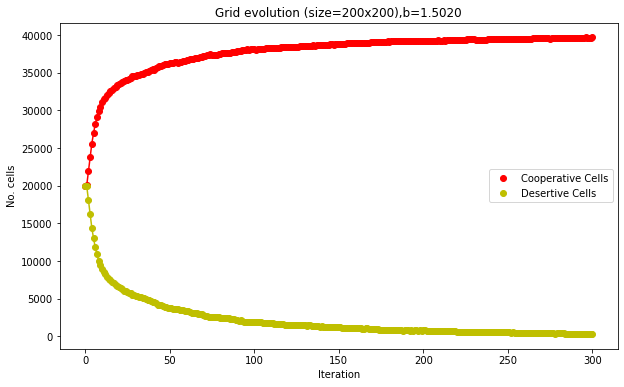

In [53]:
for dc_weight in tqdm([1.501,1.502]):
    avg_coop_hist = []
    avg_des_hist = []
    for seed in np.arange(start_seed,start_seed+num_seeds):
        coop_hist,des_hist = perform_evolution_full(num_iter,dc_weight,seed,plot_grid_state)
        
        avg_coop_hist.append(coop_hist)
        avg_des_hist.append(des_hist)
    
    avg_coop_hist = np.array(avg_coop_hist).mean(axis=0)
    avg_des_hist = np.array(avg_des_hist).mean(axis=0)
    print(f"Densidade de cooperadores = {avg_coop_hist[-1]/(avg_des_hist[-1]+avg_coop_hist[-1]):.2f}")
    plot_grid_evolution(avg_coop_hist,avg_des_hist,n_rows,n_cols,dc_weight)

* Os gráficos nos mostram que b ≈ 1.501 (ligeiramente maior que 1.5)

## Vizualizando a evolução da grid

In [44]:
n_rows = 20
n_cols = 20
num_iter = 300

K_const=0.1

  0%|          | 0/4 [00:00<?, ?it/s]

...


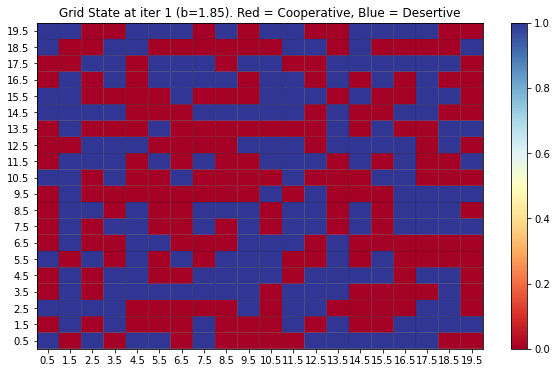

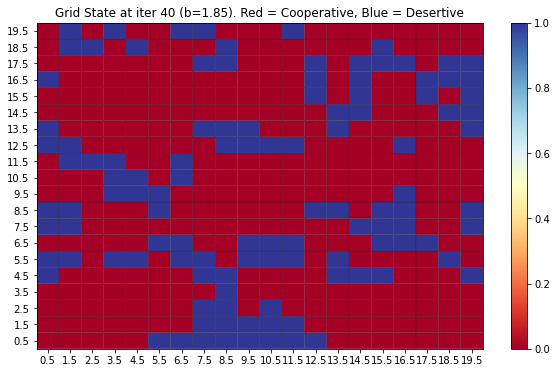

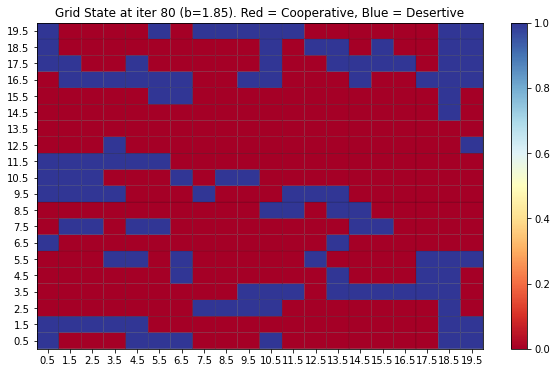

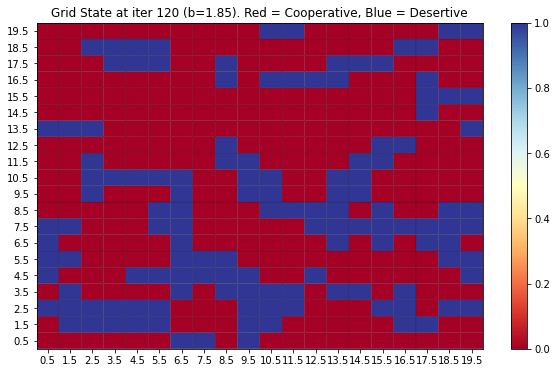

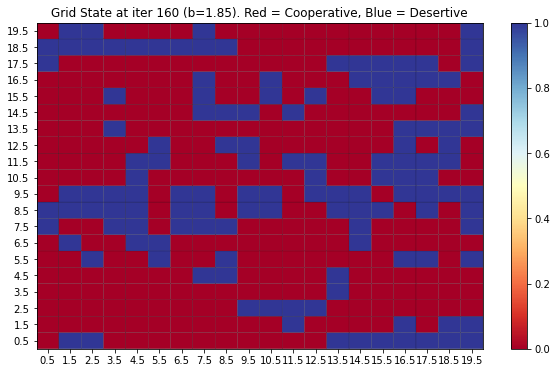

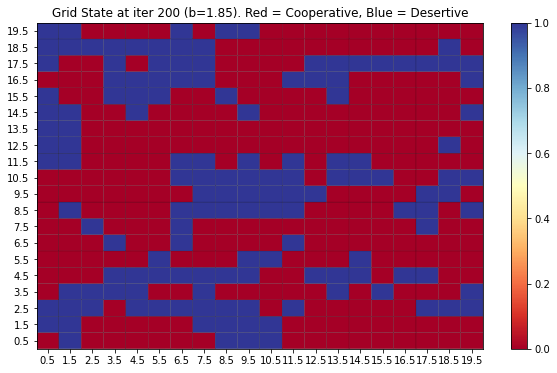

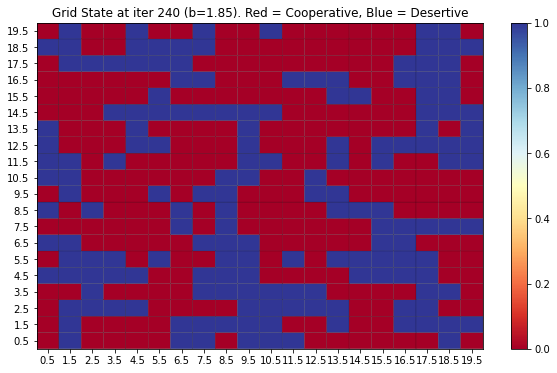

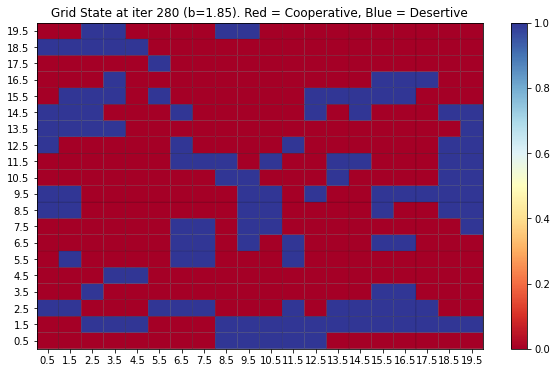

...


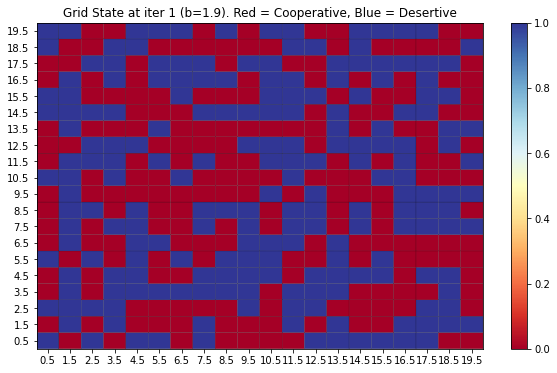

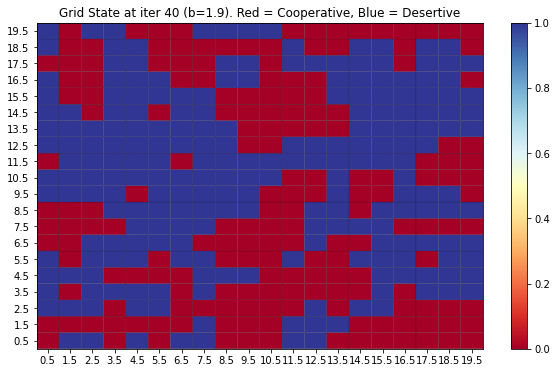

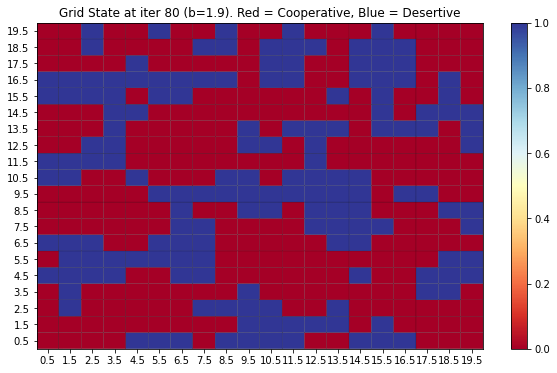

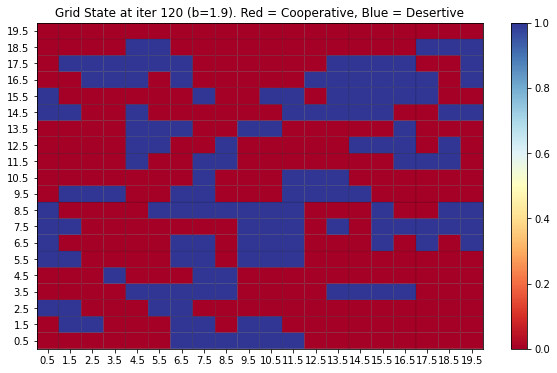

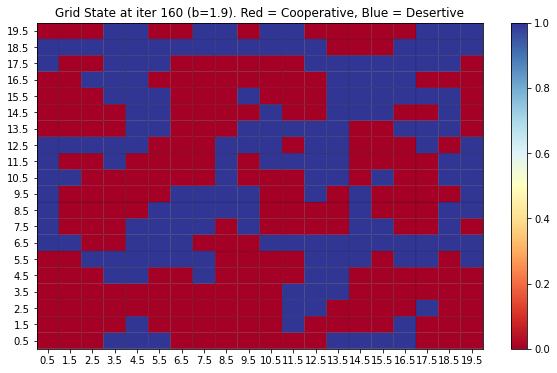

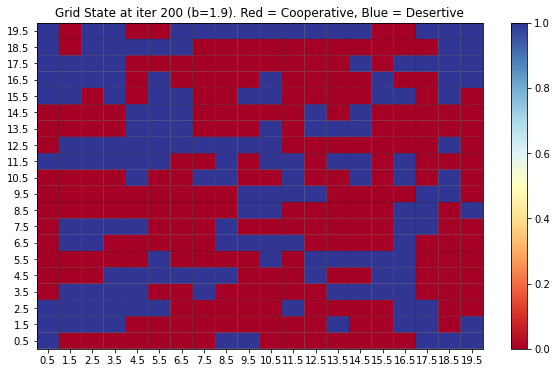

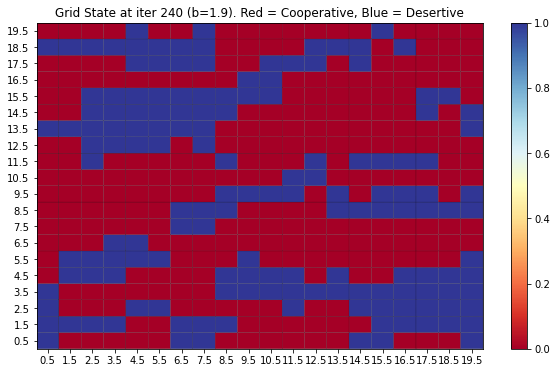

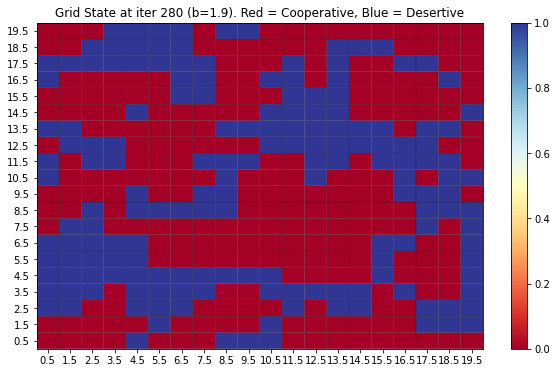

...


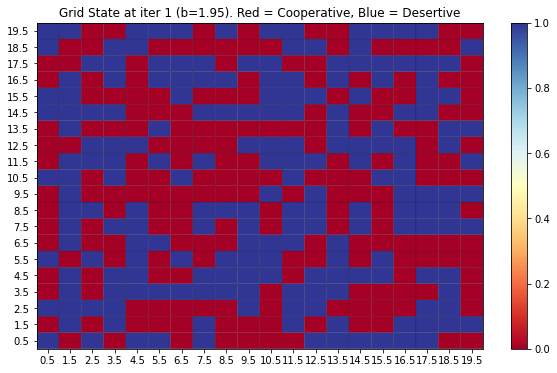

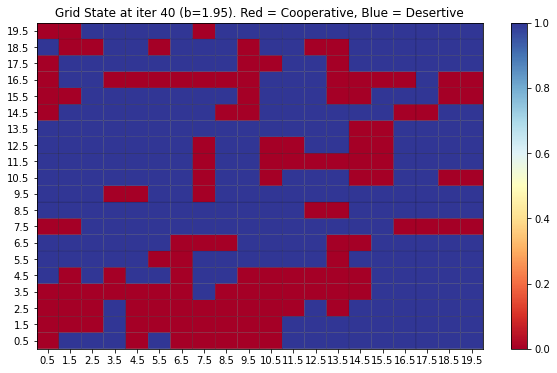

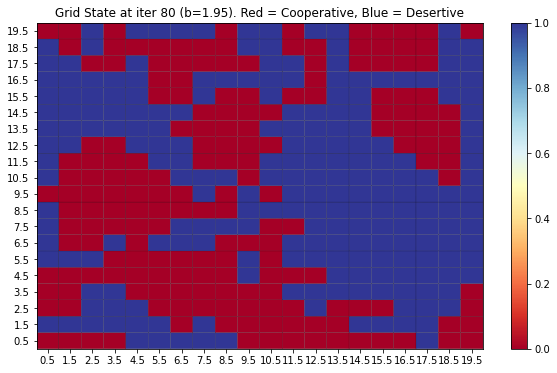

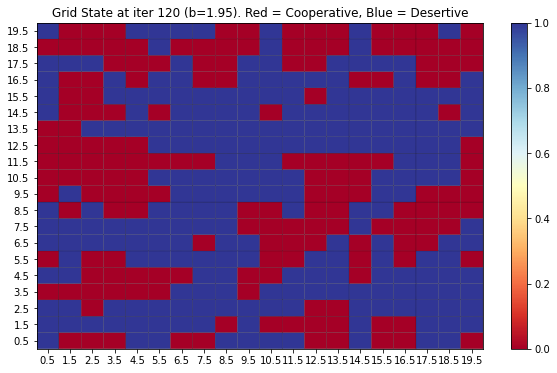

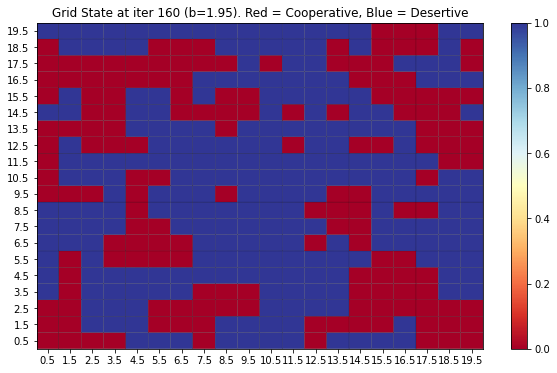

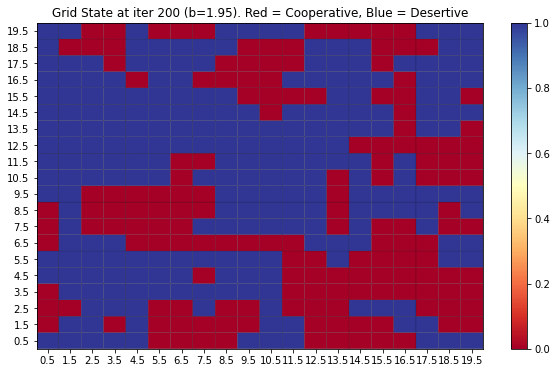

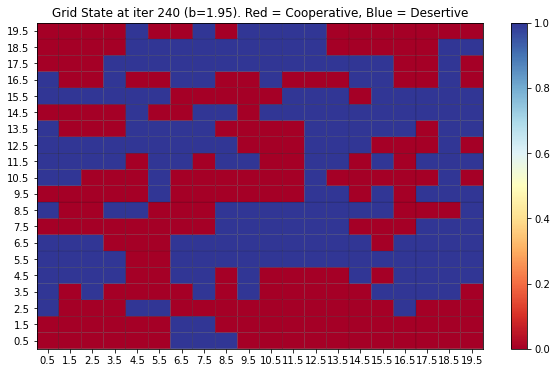

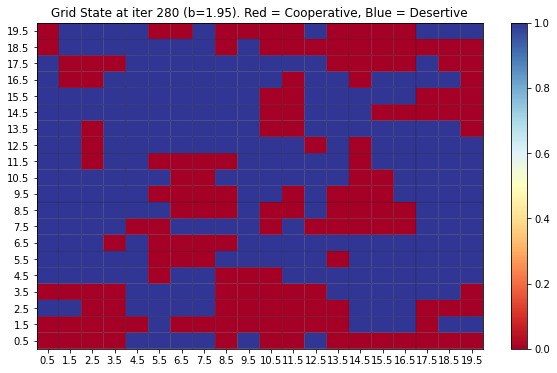

...


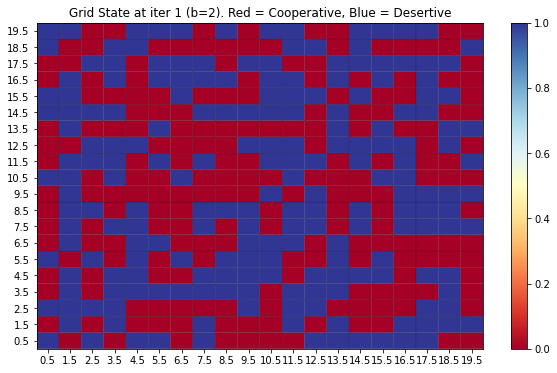

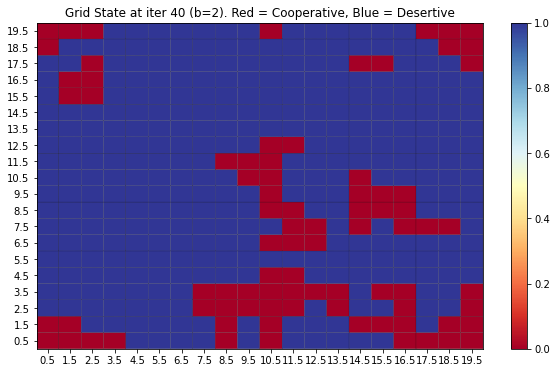

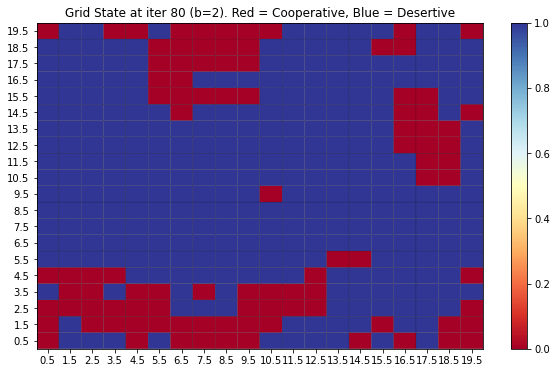

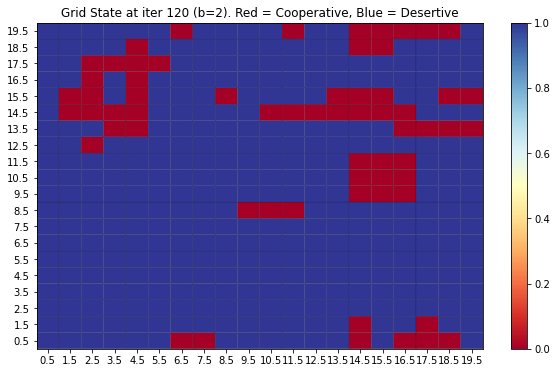

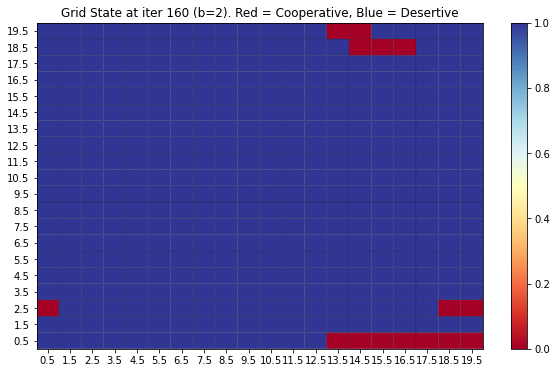

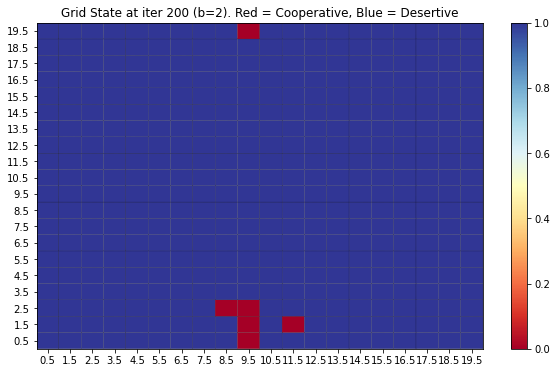

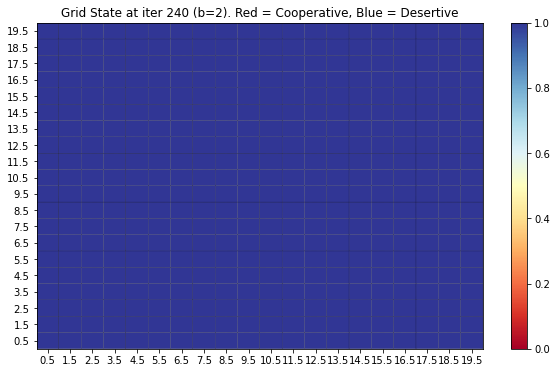

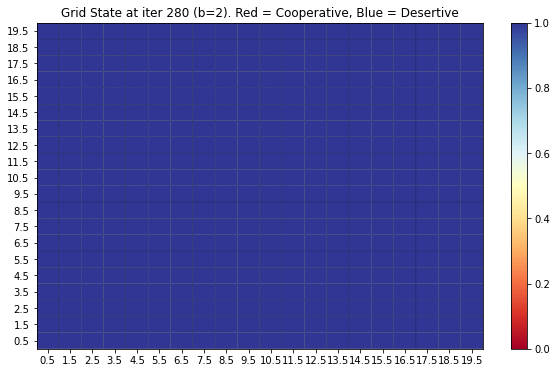

In [45]:
plot_grid_state = True
for dc_weight in tqdm([1.85,1.9,1.95,2]):
    print("...")
    avg_coop_hist = []
    avg_des_hist = []
    for seed in np.arange(start_seed,start_seed+num_seeds):
        coop_hist,des_hist = perform_evolution_full(num_iter,dc_weight,seed,plot_grid_state,40)
        
        avg_coop_hist.append(coop_hist)
        avg_des_hist.append(des_hist)
    
    
    # avg_coop_hist = np.array(avg_coop_hist).mean(axis=0)
    # avg_des_hist = np.array(avg_des_hist).mean(axis=0)
    # plot_grid_evolution(avg_coop_hist,avg_des_hist,n_rows,n_cols,dc_weight)